# 126x Faster Increased Limit Factor Calculations Using Binary Search

## Background

Actuaries calculate Increased Limit Factors (ILFs) to price various types of non-property insurance policies. With the increasing sizes of databases available to Actuaries, standard tools built in Excel start to slow to a crawl and many Actuaries have turned to R and Python to do their heavy lifting.

This notebook shows two approaches to calculating ILFs given a database of trended and developed losses, the first being an intuitive but "naive" approach, the other being less intuitive but magnitudes faster for large datasets.

While a deep understanding of ILFs is not needed to adopt the concepts in this notebook to other Actuarial problems, for those who are interested you can read about [ILFs here](https://www.casact.org/library/studynotes/palmer.pdf). Here we will focus on the main problem of calculating Limited Losses at various breakpoints and make simplifying assumptions.


## Breaking Down the Problem

Our goal is to calculate indemnity only ILFs using the loss listing we've been provided with. The ILF at limit L is calculated as:

$$
\begin{align}
ILF(L) = \frac{Limited\,Average\,Severity\,(L)}{Limited\,Average\,Severity\,(B)}
\end{align}
$$

The limited average severity is calculated simply by capping each of the losses to the corresponding limit, and taking the average of all the capped losses. For example, if we have three losses 54,000, 145,000 and 1,100,000, calculating the Limited Average Severity at 100,000 and 1,000,000 is as follows:

$$
LAS(100,000) = \frac{54,000 + 100,000 + 100,000}{3} = 84,666
$$

| Loss # | Total Loss | Limited to 100,000 | Limited to 1,000,000 |
|--------|------------|--------------------|----------------------|
| 1      | 54,000     | 54,000             | 54,000               |
| 2      | 145,000    | 100,000            | 145,000              |
| 3      | 1,100,000  | 100,000            | 1,000,000            |
| LAS    | 433,000    | 84,666             | 399,666              |




## Setup

### Data Simulation

Using the emperical data on page 6 [of the above paper](https://www.casact.org/library/studynotes/palmer.pdf), I've fit a LogNormal distribution in R and simulated 1,000,000 losses. I've stored them in a simple PostgresSQL database. 

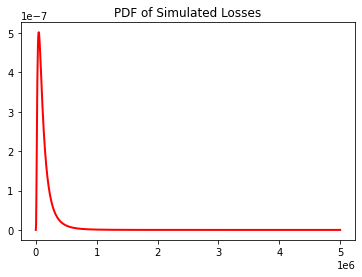

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from time import time
import psycopg2 #<- Postgres utilities

# R Fit:
# meanlog sdlog
# 11.50090134 0.84695921

mean = 11.50090134
sd = 0.84695921

x=[]

for i in range(1000000):
    x.append(np.random.lognormal(mean,sd))

# Sample Code for Inserting data into PostgresSQL
#for i in range(len(x)):
#    cur.execute("INSERT INTO liabdata (policyid, loss) VALUES (%s, %s)", (i, x[i]))

# Plot source code: https://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.random.lognormal.html
y = np.linspace(1, 5000000,1000)
pdf = (np.exp(-(np.log(y) - mean)**2 / (2 * sd**2)) / (y * mean * np.sqrt(2 * np.pi)))
plt.plot( y, pdf, linewidth=2, color='r')
plt.axis('tight')
plt.title("PDF of Simulated Losses")
plt.show()


### Variable Declaration

For this exercise, we're going to only use the first 100,000 records as otherwise you'll be waiting all day for the first algorithm to run. We'll soon see that the alternative method can process all 1M records with great efficiency.

I've provided code below to show how the data could be pulled from a PostgresSQL - for purposes of this Notebook we'll use the freshly simulated losses above. We'll also declare limits at which we want to calculate our ILFs.

In [2]:
# Sample Code for pulling data from PostgresSQL
#conn = psycopg2.connect("dbname=actuar user=ryanwilkins")
#sql = "SELECT * FROM liabdata"
#data = pd.read_sql_query(sql, conn)
#losses = data["loss"][0:100000].copy()

losses = pd.Series(x)[0:100000].copy()

# Define our Limits
# Subset: Each 100K band from 100k to 1M
limits = [(i+1)*100000 for i in range(10)]
# All: Each 100K band from 100k to 25M
limits_all = [(i+1)*100000 for i in range(250)]

print("Sample Losses")
print(losses[1:10])

Sample Losses
1     90823.847667
2    184309.965162
3     12055.954492
4    161196.093325
5     40252.833780
6    196617.820361
7     65287.683064
8     78439.947662
9    187492.154941
dtype: float64


# The Naive Algorithm

When programmers talk about Naive algorithms, they're not taking a knock at the intelligence of the person who wrote it, rather stating that the alogorithm itself is simple. This approach uses a brute force approach, comparing each loss to each limit:
___

<span style="color:blue; font-size:1.5em">Naive Algorithm for Calculating Limited Average Severity</span>

* For Each Limit of Interest, $L$
    * Loop through each loss `l`    
        * Create a storage array, `temp`    
        * if `l` < $L$:                
            * Append `l` to `temp`                   
        * else if `l` >= $L$:                
            * Append $L$ to `temp`                        
    * Take the average of `temp` and store in `Limited Losses` dictionary, at index $L$
    * Repeat for next $L$
* Output LL
___


            
            
The block below shows this algorithm coded into Python.

In [3]:
def naive_limited_loss(limits, losses):
    
    # Store the average limited losses in a dict
    LL = {}
    
    for i in range(len(limits)):
        
        # Storage Array
        temp = [0] * len(losses)
        curr_limit = limits[i]
        
        # Iterate through losses (n calls)
        for j in range(len(losses)):
            if curr_limit < losses[j]:
                temp[j] = curr_limit
            else:
                temp[j] = losses[j]
                
        # Store average in result dictionary
        LL[curr_limit] = np.mean(temp)

    return LL

### Running the Naive Algorithm

Using the 10 limits we defined above, let's run and output the LAS results as well as the time it takes to run.

In [4]:
t1 = time()
naive_ll = naive_limited_loss(limits, losses)
t2 = time()

naivedf = pd.DataFrame(naive_ll.items())
naivedf.columns = ["Limit", "LAS"]

print(naivedf)

print("Naive Limited Losses Running Time: {}".format(t2-t1))

     Limit            LAS
0   100000   77889.543239
1   200000  110010.325722
2   300000  123958.230706
3   400000  130830.905213
4   500000  134527.218097
5   600000  136688.077623
6   700000  138034.149015
7   800000  138884.671085
8   900000  139442.343075
9  1000000  139824.791256
Naive Limited Losses Running Time: 19.038751125335693


At the time of writing this, my machine displays a running time of <b> 18.73 </b> seconds. If you're thinking to yourself "That doesn't sound that long!" just remember that we're only looking at a *small* fraction of the available data, and to Actuaries working at large national carriers, that might not even be a fraction of what they have access too! Let's do a rough calculation on what we could expect the running time of the full dataset with all 250 limits to be:

$$
Running\;Time\;Estimate: 18.73\,sec * \frac{250}{10} \, Limits * \frac{1M}{100K} \, Records = 4,682\,seconds = 78 \;Minutes! 
$$

### Examining the Runtime of the Naive Algorithm

Clearly, this algorithm is not efficient for very large datasets. Although it may give you an excuse to take a longer lunch break, if you're trying to run this on a frequent basis it will get tiresome quickly.

Why is it so slow? The answer lies in looking at it's [Big-O](https://en.wikipedia.org/wiki/Big_O_notation) Runtime. Don't worry if you're not familiar with Big-O, we can still examine the algorithm and figure out the flaw.

The key is in the nested for loop in the alogrithm. Take another look at this snippet of code. Roughly, how many calculations do we have to do?


In [5]:
# Each Limit is one call - len(limits) total
for i in range(len(limits)):
    ...
    # Iterate through losses - len(losses) total
    for j in range(len(losses)):
        ...

In our small example, we're doing $len(limits) * len(losses) = 10 * 100k = 1,000,000$ calculations! The work done in this algorithm scales with the number of records, and is multiplied by a constant for the number of limits we example, and thus runs on $\mathcal{O}(kn)$ time.

# Setup For The Efficient Algorithm

The key step in the efficient setup involves first **sorting** the losses. Sorting is a fundamental concept in computer science, and there are a wide range of algorithms with different runtimes. Our data is straightforward enough that we can use [QuickSort](https://en.wikipedia.org/wiki/Quicksort), which luckily `pandas` has built right in.

Note that when comparing our new algorithm to the old, we have to be fair and include the time it takes to sort the data. 

In [6]:
t3 = time()

losses.sort_values(kind="quicksort", inplace=True)
losses = losses.reset_index(drop=True)

t4 = time()

print("QuickSort Running Time: {}".format(t4-t3))

QuickSort Running Time: 0.02524590492248535


## Binary Search 

The new algorithm will be based around the [Binary Search Algorithm](https://en.wikipedia.org/wiki/Binary_search_algorithm). The BSA will return the `index` of a search value `x` from a **sorted** array `arr`, with at most $\log{}(n)$ (to be precise - $\log{}_{2}(n)$) calls. How fast is $\log{}(n)$? Let's examine the number of calls to the sort function needed in the worst case, versus [Linear Search](https://en.wikipedia.org/wiki/Linear_search) (searching left to right):

| Number of Records | Linear Search O(n) | Binary Search O(log n) |
|-------------------|--------------------|------------------------|
| 100               | 100                | 7                      |
| 1,000             | 1,000              | 10                     |
| 100,000           | 100,000            | 17                     |
| 1,000,000         | 1,000,000          | 20                     |

Here I have written a custom Binary Search function. Note there are many available pre-made options out there, however because this is the focal pont of our analysis I want to explicitly show how it works. Optimizing this function for all the corner cases (i.e. loss list of size 0) is an exercise left up to the reader.

In [7]:
def bin_loss_search(losses, x, l ,r):
    if l<r:
        m = (l+r)//2
        if (losses[m] <= x) and (losses[m+1] >= x):
            # Return the index to the closest matching loss
            return m
        if losses[m] < x:
            return bin_loss_search(losses, x, m, r)
        else:
            return bin_loss_search(losses, x, l, m)

A quick test of `bin_loss_search` should show it working as expected:

In [8]:
# Find the position where 1M losses start:
mil_loss_index = bin_loss_search(losses, 1000000, 0 , len(losses)-1)
print("The index of the first loss >= 1M is {}. Surrounding losses: {}, {}, {}".format(mil_loss_index,
                                                                                       losses[mil_loss_index-1],
                                                                                       losses[mil_loss_index],
                                                                                       losses[mil_loss_index+1]))

The index of the first loss >= 1M is 99676. Surrounding losses: 999403.0750694824, 999565.091724513, 1000266.0079334187


## Defining The Efficient Algorithm

Before we write the algorithm, take a second to consider what we know about our data so far:

1. The `losses` are sorted from smallest to largest
2. `bin_loss_search` return the index for the first loss equal to or greater than the input
3. All losses after the `bin_loss_search` index will be greater than the input 

___

<span style="color:blue; font-size:1.5em">Efficient Algorithm for Calculating Limited Average Severity</span>

1. Sort `losses`
2. With Sorted `losses`:
    * For Each Limit, $L$:
        * Using `bin_loss_search` find index $i_{L}$ in `losses` where `losses[i_L]` $<= L <=$  `losses[i_L + 1]`
        * Create `temp` of length `len(losses)`
        * Set `temp[0:i_l]` = `losses[0:i_l]`
        * Set `temp[i_l:len(losses)]` = $L$
        * Take the average of `temp` and store in `LL`
3. Return `LL`
    
___

In code:


In [9]:
def quick_limited_loss(limits, losses):
    LL = {}

    for i in range(len(limits)):
        
        curr_limit = limits[i]
        curr_index = bin_loss_search(losses, curr_limit, 0, len(losses)-1)
        temp = [0] * len(losses)
        temp[0:curr_index] = losses[0:curr_index]
        temp[curr_index:len(losses)] = [curr_limit] * (len(losses)-curr_index)

        LL[curr_limit] = np.mean(temp)

    return LL

See the difference? By using the fact that we know the `losses` are now in order, we can totally avoid looping through the whole dataset for each limit, and in fact the only computation needed for each limit involves setting up the `temp` array!

### Running the Efficient Algorithm

Using the same input as above, let's run `quick_limited_loss` and see if the output matches.

In [10]:
t5 = time()
quick_ll = quick_limited_loss(limits, losses)
t6 = time()

quickdf = pd.DataFrame(quick_ll.items())
quickdf.columns = ["Limit", "LAS"]

print(quickdf)

print("Quick Limited Loss Run Time: {}".format(t6-t5))
print("Including Sort Run Time: {}".format(t4-t3+t6-t5))

     Limit            LAS
0   100000   77889.543244
1   200000  110010.325794
2   300000  123958.230950
3   400000  130830.905407
4   500000  134527.219146
5   600000  136688.080328
6   700000  138034.149359
7   800000  138884.671459
8   900000  139442.347283
9  1000000  139824.795605
Quick Limited Loss Run Time: 0.2436990737915039
Including Sort Run Time: 0.26894497871398926


The runtime of this algorithm on my machine, including the QuickSort, is **0.175 seconds**! Nice! 

Using the same exercise as before, let's estimate the runtime for the whole dataset and all limits. Noting that the 10 limits took **0.1576 seconds**, and ignoring the marginal extra time to sort 900K more records (thanks QuickSort!), a rough runtime estimate is:

$$
Running\;Time\;Estimate: 0.1576\,sec * \frac{250}{10} \, Limits * \frac{1M}{100K} \, Records = 39.42 \; seconds
$$

Actually running the algorithm on my machine shows that our estimate is pretty accurate:

### Examining the Runtime of the Efficient Algorithm

Why is this new algorithm so much faster? As we've already discussed, this new algorithm only needs to create the `temp` array, and doesn't need to use a `for` loops to make `len(losses)` comparisons for each $L$. 

Let's look at the running time each step of the algorithm:

* QuickSort: $\mathcal{O}(n\log{}n)$ (Average): Though worst case QuickSort runs in $\mathcal{O}(n^2)$ time, for all practical applications the average speed is applicable. Our example above has shown that the `pandas` implementation of QuickSort is fast enough to sort 1M records in negligible time.

* BinSearch: $\mathcal{O}(\log{}n)$: As discussed, the numbers of calls to BinSearch are at most ~17 for our 100,000 records.

* Limits Loop: $\mathcal{O}(k\log{}n)$: For each limit in the table, we do a binary search, and an additional amount of work that scales with n to provision `temp`, but it negligable when compared to $k\log{}n$.

The smart reader will notice that for small values of `n` and `k`, it's possible for the Naive algorithm to outperform the Efficient algorithm. However, for any study with numbers that small, Excel would probably suffice.

How much faster is the Efficient algorithm? Let's take a look at our example of 10 limits and 100,000 records:

In [11]:
print("Naive Method Total Time:{}".format(t2-t1))
print("Sorted Method Total Time: {}".format(t4-t3+t6-t5))
print("Naive Method Time Relative to Sorted: {}".format((t2-t1)/(t4-t3+t6-t5)))

Naive Method Total Time:19.038751125335693
Sorted Method Total Time: 0.26894497871398926
Naive Method Time Relative to Sorted: 70.79050598517601


$$
Slow\;Algorithm: 20.18\;Seconds
$$
$$
Fast\;Algorithm: 0.159\;Seconds
$$
$$
126\; Times \; Faster!
$$

## Rounding Out the Analysis and Extensions

Let's calculate and output the actual ILFs to make our analysis complete. Using the Basic Limits Loss of 100,000 the ILFs can be found via a few lines of code:

In [12]:
quickdf["ILF"] = quickdf["LAS"]/(quick_ll[100000])

print(quickdf)                    

     Limit            LAS       ILF
0   100000   77889.543244  1.000000
1   200000  110010.325794  1.412389
2   300000  123958.230950  1.591462
3   400000  130830.905407  1.679698
4   500000  134527.219146  1.727154
5   600000  136688.080328  1.754896
6   700000  138034.149359  1.772178
7   800000  138884.671459  1.783098
8   900000  139442.347283  1.790258
9  1000000  139824.795605  1.795168


Easy!

Now, our Efficient Algorithm still has room for improvement. For example, can you think of a faster way to calculate the numerator of the LAS? Do we actually need to fill out the rest of `temp` with $L$? Leave me a comment and let me know what other ways you can think to improve the algorithm.